## SMS Spam or Ham Classification using NLP

SMS Spam Ham Classification using Natural Language Processing

#### Workflow stages :
1. Data understanding and exploration
2. Feature engineering
3. Exploratory data analysis (EDA)
4. Data Preprocessing
5. Model building 
6. Model evaluation

### Importing Libraries

In [43]:
# Import libraries
import pandas as pd
import numpy as np
import string
from wordcloud import WordCloud 
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# NLP
import nltk
from nltk.corpus import stopwords
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Training
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import cross_val_score

# Saving 
import pickle

### 1. Data understanding and exploration

#### Importing the data

In [2]:
df = pd.read_csv('data\\spam.csv', encoding='latin-1')

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


- Removing unwanted columns 
- Renaming the columns to label and message

In [4]:
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
df = df.rename(columns={"v2" : "message", "v1":"label"})

In [5]:
print("Shape of dataset : {}".format(df.shape))
print("Unique values of label column : {}".format(df['label'].unique()))
df.head()

Shape of dataset : (5572, 2)
Unique values of label column : ['ham' 'spam']


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Our dataset contains 5572 observation and 2 characterisitics label : dependant variable, message :independant variable)

In [6]:
# Null Values
df.isnull().sum()

label      0
message    0
dtype: int64

In [7]:
# Duplicate
df.duplicated().sum()

403

In [8]:
## Drop the duplicated values
df = df.drop_duplicates(keep='first')

In [9]:
print("Number of spam messages: {}".format(len(df[df["label"] == "spam"]['message'])))
print("Number of spam messages: {}".format(len(df[df["label"] == "ham"]['message'])))

Number of spam messages: 653
Number of spam messages: 4516


In [10]:
df['label'].value_counts()

ham     4516
spam     653
Name: label, dtype: int64

Ham messages are more than spam messages

### 2. Feature engineering

We will ADD the following columns to the dataframe:

    word_count : The number of words
    sentence_count : The number of sentences
    brackets_count : The number of text between brackets
    links_count : The number of links
    phone_count : The number of phone numbers
    money_count : The number of money amounts

In [11]:
class AddFeatures(BaseEstimator, TransformerMixin):

    def __init__(self):
      nltk.download('punkt', quiet=True)
    
    def count_words(self, input_text):
        # remove punctuation, tokenize and return the number of tokens (words)
        message = input_text.translate(str.maketrans('', '', string.punctuation))
        return len(nltk.word_tokenize(input_text))

    def count_sentences(self, input_text):
        return len(nltk.sent_tokenize(input_text.lower()))

    def count_brackets(self, input_text):
        return len(re.findall(r'<[a-zA-Z0-9\s]+>+', input_text.lower()))

    def count_links(self, input_text):
        return len(re.findall(r'https?://\S+|www\.\S+', input_text.lower()))

    def count_phone(self, input_text):
        return len(re.findall(r'\d{5,}', input_text.lower()))

    def count_money(self, input_text):
        return len(re.findall(r'[$|£|€]\d+', input_text.lower()))+len(re.findall(r'\d+[$|£|€]', input_text.lower()))

    def transform(self, df, y=None):
        df['word_count'] = df.message.apply(self.count_words)
        df['sentence_count'] = df.message.apply(self.count_sentences)
        df['brackets_count'] = df.message.apply(self.count_brackets)
        df['links_count'] = df.message.apply(self.count_links)
        df['phone_count'] = df.message.apply(self.count_phone)
        df['money_count'] = df.message.apply(self.count_money)
        return df
    def fit(self, df, y=None):
        return self


In [12]:
af = AddFeatures()

df = af.fit_transform(df)

df.sample(10)

,label,message,word_count,sentence_count,brackets_count,links_count,phone_count,money_count
1945,ham,Can Ì_ call me at 10:10 to make sure dat i've ...,15,1,0,0,0,0
3887,ham,ok....take care.umma to you too...,8,1,0,0,0,0
4362,ham,Evry Emotion dsn't hav Words.Evry Wish dsn't h...,44,1,0,0,0,0
2221,ham,I notice you like looking in the shit mirror y...,15,1,0,0,0,0
2263,spam,Not heard from U4 a while. Call 4 rude chat pr...,36,4,0,0,1,0
3471,ham,I think IÛ÷m waiting for the same bus! Inform...,22,2,0,0,0,0
1347,ham,She doesnt need any test.,6,1,0,0,0,0
5227,ham,I re-met alex nichols from middle school and i...,15,1,0,0,0,0
4315,ham,"I can't speak, bcaz mobile have problem. I can...",28,3,0,0,0,0
1667,ham,So now my dad is gonna call after he gets out ...,21,1,0,0,0,0


### 3. EDA (Exploratory data analysis)

In [13]:
df.describe()

,word_count,sentence_count,brackets_count,links_count,phone_count,money_count
count,5169.000000,5169.000000,5169.000000,5169.000000,5169.000000,5169.000000
mean,18.453279,1.863803,0.001161,0.017605,0.126524,0.054943
std,13.324793,1.286399,0.034054,0.131523,0.421751,0.275550
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,15.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,26.000000,2.000000,0.000000,0.000000,0.000000,0.000000
max,220.000000,24.000000,1.000000,1.000000,3.000000,3.000000


In [14]:
# for HAM messages 
df[df.label=='ham'].describe()

,word_count,sentence_count,brackets_count,links_count,phone_count,money_count
count,4516.000000,4516.000000,4516.0,4516.000000,4516.000000,4516.000000
mean,17.120903,1.724092,0.0,0.000221,0.000664,0.003543
std,13.493725,1.203559,0.0,0.014881,0.025768,0.078670
min,1.000000,1.000000,0.0,0.000000,0.000000,0.000000
25%,8.000000,1.000000,0.0,0.000000,0.000000,0.000000
50%,13.000000,1.000000,0.0,0.000000,0.000000,0.000000
75%,22.000000,2.000000,0.0,0.000000,0.000000,0.000000
max,220.000000,24.000000,0.0,1.000000,1.000000,3.000000


In [15]:
# for SPAM messages 
df[df.label=='spam'].describe()

,word_count,sentence_count,brackets_count,links_count,phone_count,money_count
count,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000
mean,27.667688,2.830015,0.009188,0.137825,0.996937,0.410413
std,7.008418,1.419697,0.095488,0.344981,0.732667,0.643525
min,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,2.000000,0.000000,0.000000,1.000000,0.000000
50%,29.000000,3.000000,0.000000,0.000000,1.000000,0.000000
75%,32.000000,4.000000,0.000000,0.000000,1.000000,1.000000
max,46.000000,8.000000,1.000000,1.000000,3.000000,3.000000


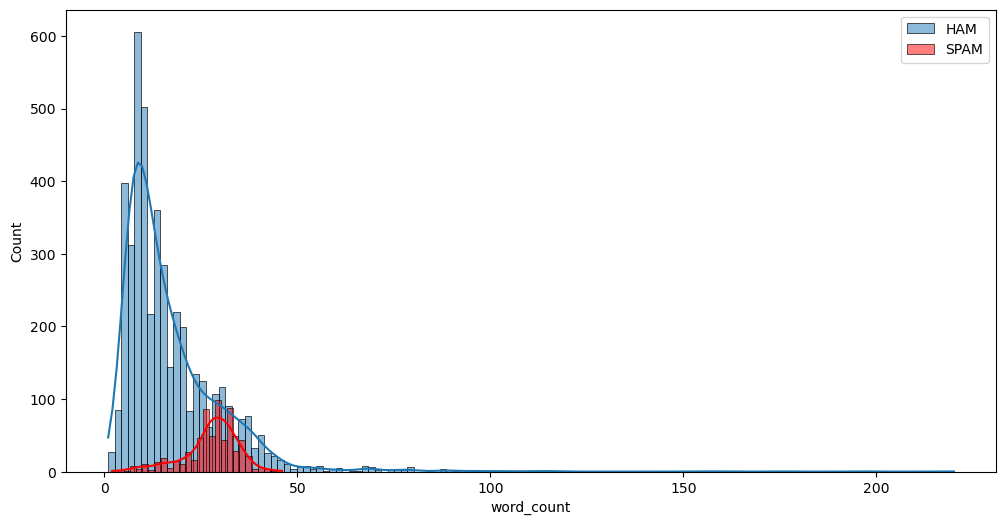

In [16]:
plt.figure(figsize=(12,6))
sns.histplot(df[df.label=='ham']['word_count'],label='HAM',kde=True)
sns.histplot(df[df.label=='spam']['word_count'],color='red',label='SPAM',kde=True)
plt.legend()

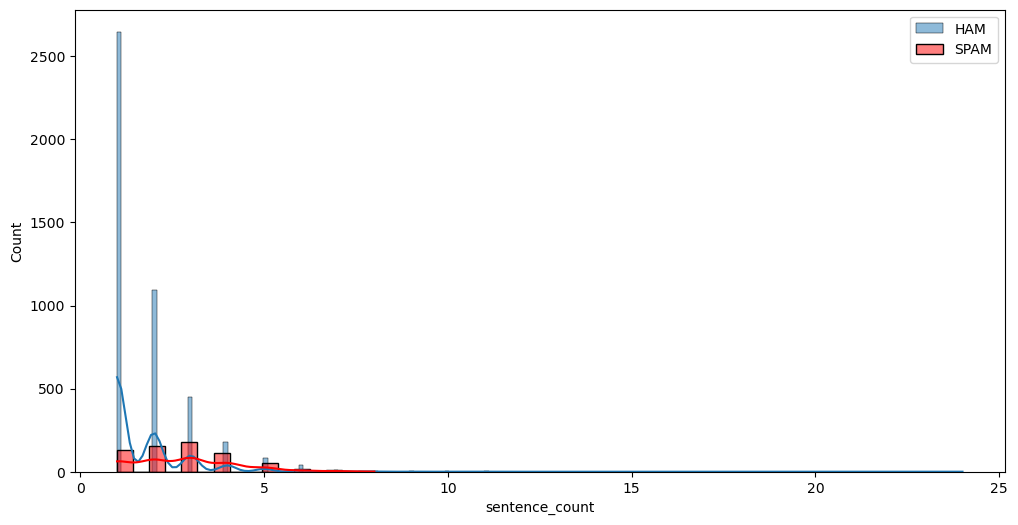

In [17]:
plt.figure(figsize=(12,6))
sns.histplot(df[df.label=='ham']['sentence_count'],label='HAM',kde=True)
sns.histplot(df[df.label=='spam']['sentence_count'],color='red',label='SPAM',kde=True)
plt.legend()

### 4. Data Preprocessing
- For the text feature : removes punctuations, stop-words, and non-alphabets.
- Bag of Words (BoW)
- Term Frequency-Inverse Document Frequency (TF-IDF)

#### Stop Word Removal
Stop words are commonly occurring words such as articles, pronouns, and prepositions. The removal process excludes the unnecessary words of little value and helps us focus more on the text that requires our attention.

In [18]:
# Class derived from BaseEstimator and TransformerMixin (sklearn) classes.
class TextPreprocess (BaseEstimator, TransformerMixin):
    def __init__(self):
        nltk.download('stopwords', quiet=True) # Download stopwords

    def to_lower(self, text):
        return str(text).lower()
    
    def replace_brackets(self, input_text):
        # Replace text between brackets with 'bracketstext' (spam messages)
        return re.sub('<.*?>+', ' brackets_text ', input_text)

    def replace_money(self, input_text):
        # Replace money amounts ($123 or 1£) with 'moneytext'
        input_text = re.sub(r'[$|£|€]\d+', ' money_text ', input_text)
        return re.sub(r'\d+[$|£|€]', ' money_text ', input_text)

    def replace_currency(self, input_text):
        # Replace remaining currency symbols with 'currsymb'
        return re.sub(r'[$|£|€]', ' curr_symb ', input_text)

    def replace_urls(self, input_text):
        # Replace links with 'weblink'
        link_regex = r'(http(s)?:\/\/.)?(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)'
        link_regex1 = r'https?://\S+|www\.\S+'
        link_regex2 = r'http.?://[^\s]+[\s]?'
        return re.sub(link_regex1, ' weblink ', input_text)

    def remove_punc(self, text):
        nopunc = [char for char in text if char not in string.punctuation]
        return "".join(nopunc)

    def remove_stopwords(self, text):
        nostop =   [
                    word
                    for word in text.split()
                    if word.lower() not in stopwords.words("english") and word.isalpha()
                    ]
        return nostop

    def transform(self, df, **transform_params):
        clean_txt = df.apply(self.to_lower)
        clean_txt = clean_txt.apply(self.replace_brackets)
        clean_txt = clean_txt.apply(self.replace_money)
        clean_txt = clean_txt.apply(self.replace_currency)
        clean_txt = clean_txt.apply(self.replace_urls)
        clean_txt = clean_txt.apply(self.remove_punc)
        clean_txt = clean_txt.apply(self.remove_stopwords)
        clean_txt = clean_txt.agg(lambda x: " ".join(map(str, x)))
        return clean_txt

    def fit(self, X, y=None, **fit_params):
        return self

Check if some some rows do not have any words left after cleaning. And replace them with some placeholder text like no_text.

In [19]:
ct = TextPreprocess()

clean_msg = ct.fit_transform(df.message)
clean_msg[clean_msg == '']
clean_msg.loc[clean_msg == ''] = 'no_text'

In [20]:
# Add clean_msg to our dataset
df['clean_msg'] = clean_msg

#### Top words in ham and spam messages.

In [21]:
spam_messages = df[df["label"] == "spam"]
spam_words = []
# spam messages
for message in spam_messages.clean_msg:
    spam_words += message.split()

spam_count = pd.Series(spam_words).value_counts()
print("Top 10 spam words are:\n {}\n".format(spam_count.head(10)))

Top 10 spam words are:
 call         304
moneytext    268
å            241
free         189
txt          126
u            123
ur           119
mobile       105
stop         103
text         103
dtype: int64



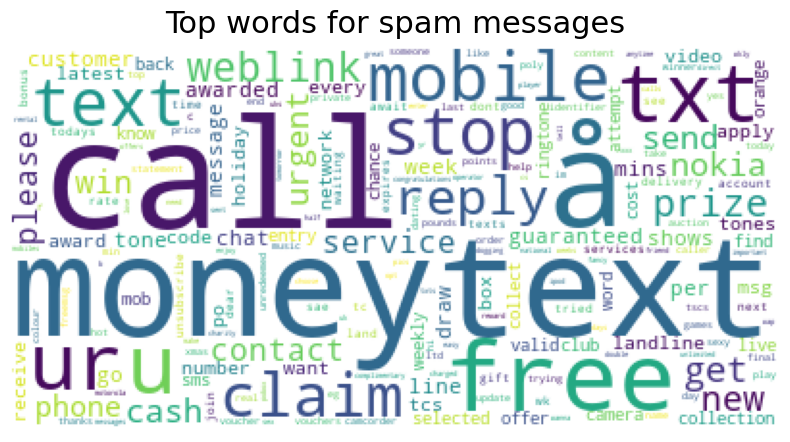

In [27]:
wc = WordCloud(
    background_color='white', 
    max_words=200,
)
wc.generate_from_frequencies(frequencies=spam_count)
plt.figure(figsize=(12,5))
plt.title('Top words for spam messages', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

In [28]:
# ham messages
ham_messages = df[df["label"] == "ham"]

ham_words = []
for message in ham_messages.clean_msg:
    ham_words += message.split()

ham_count = pd.Series(ham_words).value_counts()
print("Top 10 spam words are:\n {}\n".format(ham_count.head(10)))

Top 10 spam words are:
 u       878
im      434
get     295
ltgt    254
ok      246
dont    242
go      239
got     225
know    221
like    219
dtype: int64



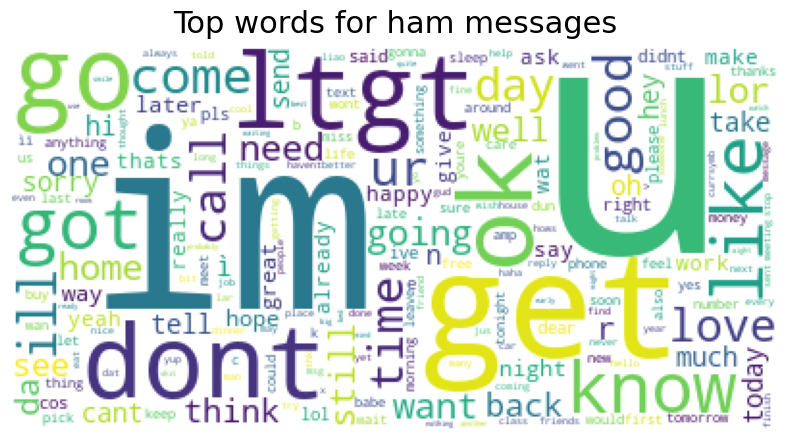

In [29]:
wc = WordCloud(
    background_color='white', 
    max_words=200,
)
wc.generate_from_frequencies(frequencies=ham_count)
plt.figure(figsize=(12,5))
plt.title('Top words for ham messages', 
          fontdict={'size': 22,  'verticalalignment': 'bottom'})
plt.imshow(wc)
plt.axis("off")
plt.show()

### 5. Model building 

#### Target Encoding

In [30]:
# Target Encoding (spam = 1 / ham = 0)
encoder = LabelEncoder()
targets = encoder.fit_transform(df.label)

df['label'] = targets
df.head()

,label,message,word_count,sentence_count,brackets_count,links_count,phone_count,money_count,clean_msg
0,0,"Go until jurong point, crazy.. Available only ...",24,1,0,0,0,0,go jurong point crazy available bugis n great ...
1,0,Ok lar... Joking wif u oni...,8,1,0,0,0,0,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,37,1,0,0,2,0,free entry wkly comp win fa cup final tkts may...
3,0,U dun say so early hor... U c already then say...,13,1,0,0,0,0,u dun say early hor u c already say
4,0,"Nah I don't think he goes to usf, he lives aro...",15,1,0,0,0,0,nah dont think goes usf lives around though


#### Splitting data into train and test

In [31]:
# Split the dataset to train and test sets
X = df.drop(['label'], axis=1)
Y = df["label"]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=13,
                                                    shuffle=True , stratify=df["label"])

In [32]:
print('Train shapes:', x_train.shape, y_train.shape,'\nTest shapes:', x_test.shape, y_test.shape)

Train shapes: (4135, 8) (4135,) 
Test shapes: (1034, 8) (1034,)


In [33]:
x_train

,message,word_count,sentence_count,brackets_count,links_count,phone_count,money_count,clean_msg
2533,Glad it went well :) come over at 11 then we'l...,23,1,0,0,0,0,glad went well come well plenty time claire go...
1958,"Lol ... Oh no babe, I wont be sliding into you...",21,1,0,0,0,0,lol oh babe wont sliding place midnight thanks...
219,Yeah you should. I think you can use your gt a...,40,4,0,0,0,0,yeah think use gt atm register sure theres any...
4348,ÌÏ bot notes oredi... Cos i juz rem i got...,12,1,0,0,0,0,ìï bot notes oredi cos juz rem got
1929,Free 1st week entry 2 TEXTPOD 4 a chance 2 win...,30,2,0,1,2,1,free week entry textpod chance win ipod å mone...
...,...,...,...,...,...,...,...,...
3635,\ME 2 BABE I FEEL THE SAME LETS JUST 4GET ABOU...,22,1,0,0,0,0,babe feel lets itboth try cheer upnot fit soo ...
3126,Thats cool. i liked your photos. You are very ...,13,3,0,0,0,0,thats cool liked photos sexy
28,"I'm back &amp; we're packing the car now, I'll...",22,1,0,0,0,0,im back amp packing car ill let know theres room
1661,"You aren't coming home between class, right? I...",18,2,0,0,0,0,arent coming home class right need work shower


### Vectorization

#### - Bag of Words (BoW)

A bag of words counts the occurrences of words in the text, disregarding the order of words and the structure of the document.

Wel will use CountVectorizer() class from the scikit-learn library to fitch the hole vocabulary than we transform the string messages to numerical vectors to simplify the model-building and training process.

#### - TF-IDF
Term Frequency-Inverse Document Frequency (TF-IDF) helps in rescaling the frequency of words by how often they appear in the texts.

In [34]:
class ColumnExtractor(TransformerMixin, BaseEstimator):
    def __init__(self, cols):
        self.cols = cols

    def transform(self, X, **transform_params):        
        return X[self.cols]

    def fit(self, X, y=None, **fit_params):
        return self
    
textcountscols = ['word_count', 'sentence_count', 'brackets_count', 'links_count', 'phone_count', 'money_count']

def grid_vect(clf, clf_params, x_train, y_train, x_test, y_test, parameters_text=None, vectorizer=None, cv_nb=5):
    
    vect_pipe = Pipeline([
                        ('cleantext', ColumnExtractor(cols='clean_msg')),
                        ('vect', vectorizer)
                        ])

    col_ext = ColumnExtractor(cols=textcountscols)
    features = FeatureUnion([('textcounts', col_ext), 
                             ('pipe', vect_pipe)], 
                             n_jobs=1)
    
    pipeline = Pipeline([('features', features),
                         ('clf', clf)])

    # Join both parameters dictionaries together
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(clf_params)
    
    grid_search = GridSearchCV(pipeline, parameters, scoring='f1', n_jobs=-1, verbose=2, cv=cv_nb)
    
    grid_search.fit(x_train, y_train)
    print("Grid Search Results :")
    print(f"Best CV score: {grid_search.best_score_}")
    print("Best parameters :")

    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print(f"\t{param_name}: {best_parameters[param_name]}")

    GS_best_estimator = grid_search.best_estimator_
    print(f"Train score with best_estimator_: {GS_best_estimator.score(x_train, y_train):.3f}")
    print(f"Test score with best_estimator_: {GS_best_estimator.score(x_test, y_test):.3f}")

    print("Classification Report Test Data")
    print(classification_report(y_test, GS_best_estimator.predict(x_test), target_names=['ham','spam']))
    
    mat = confusion_matrix(y_test, GS_best_estimator.predict(x_test))
    sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap='coolwarm', linewidths=5)
    plt.xlabel('predicted value')
    plt.ylabel('true value')
    plt.show()

    return grid_search

In [35]:
# Parameter grid settings for the vectorizers
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1, 2, 3)
}

# Parameter grid settings for KNN
parameters_knn = {
    'clf__n_neighbors': (3, 5, 7, 8, 9, 10, 25, 30, 50, 70, 74)
}

# Parameter grid settings for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.00001, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.75, 0.8, 0.9, 1.0)
}

### 6. Model evaluation

In [38]:
# Classifiers
knn = KNeighborsClassifier()
mnb = MultinomialNB()

# CountVectorizer
c_vect = CountVectorizer()
tfidf_vect = TfidfVectorizer()

Fitting 5 folds for each of 198 candidates, totalling 990 fits
Grid Search Results :
Best CV score: 0.8262361310187398
Best parameters :
	clf__n_neighbors: 3
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 1)
Train score with best_estimator_: 0.975
Test score with best_estimator_: 0.956
Classification Report Test Data
              precision    recall  f1-score   support

         ham       0.96      0.99      0.98       903
        spam       0.95      0.69      0.80       131

    accuracy                           0.96      1034
   macro avg       0.95      0.84      0.89      1034
weighted avg       0.96      0.96      0.95      1034



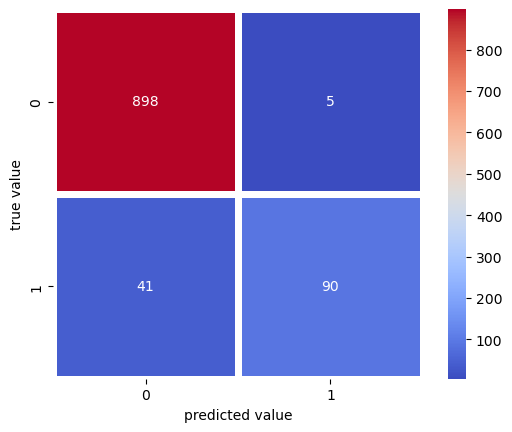

In [44]:
# KNN x CountVectorizer
knn_countvect = grid_vect(knn, parameters_knn, x_train, y_train, x_test, y_test, parameters_text=parameters_vect, vectorizer=c_vect)

Fitting 5 folds for each of 198 candidates, totalling 990 fits
Grid Search Results :
Best CV score: 0.8545022957329816
Best parameters :
	clf__n_neighbors: 3
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 1)
Train score with best_estimator_: 0.979
Test score with best_estimator_: 0.961
Classification Report Test Data
              precision    recall  f1-score   support

         ham       0.96      0.99      0.98       903
        spam       0.95      0.73      0.83       131

    accuracy                           0.96      1034
   macro avg       0.96      0.86      0.90      1034
weighted avg       0.96      0.96      0.96      1034



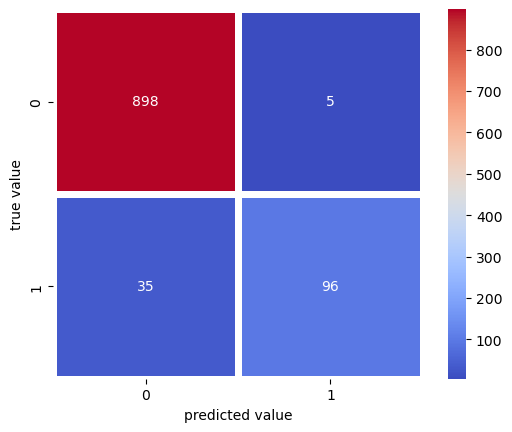

In [45]:
# KNN x TF-IDF
knn_tfidf = grid_vect(knn, parameters_knn, x_train, y_train, x_test, y_test, parameters_text=parameters_vect, vectorizer=tfidf_vect)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Grid Search Results :
Best CV score: 0.9430852226615549
Best parameters :
	clf__alpha: 0.5
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 1)
Train score with best_estimator_: 0.993
Test score with best_estimator_: 0.986
Classification Report Test Data
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       903
        spam       0.95      0.95      0.95       131

    accuracy                           0.99      1034
   macro avg       0.97      0.97      0.97      1034
weighted avg       0.99      0.99      0.99      1034



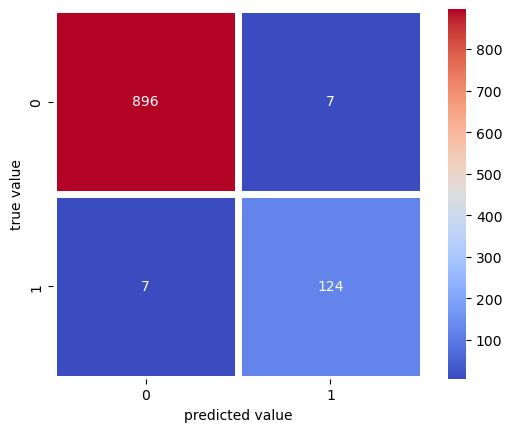

In [46]:
# MultinomialNB x CountVectorizer
mnb_countvect = grid_vect(mnb, parameters_mnb, x_train, y_train, x_test, y_test, parameters_text=parameters_vect, vectorizer=c_vect)

Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Grid Search Results :
Best CV score: 0.9451973109961503
Best parameters :
	clf__alpha: 0.01
	features__pipe__vect__max_df: 0.25
	features__pipe__vect__min_df: 1
	features__pipe__vect__ngram_range: (1, 2)
Train score with best_estimator_: 0.999
Test score with best_estimator_: 0.988
Classification Report Test Data
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       903
        spam       0.95      0.96      0.95       131

    accuracy                           0.99      1034
   macro avg       0.97      0.98      0.97      1034
weighted avg       0.99      0.99      0.99      1034



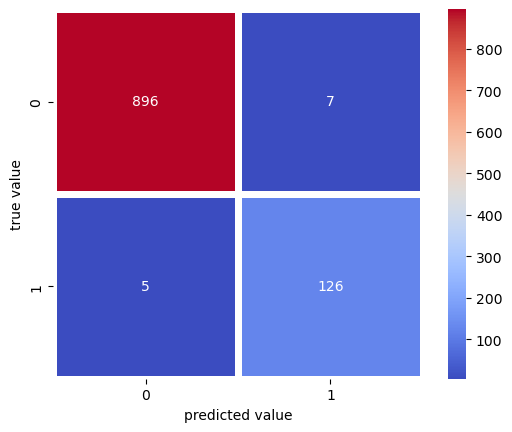

In [47]:
# MultinomialNB x TF-IDF
mnb_countvect = grid_vect(mnb, parameters_mnb, x_train, y_train, x_test, y_test, parameters_text=parameters_vect, vectorizer=tfidf_vect)

#### Comparing MultinomialNB x CountVectorizer AND MultinomialNB x CountVectorizer

In [48]:
def cross_validation(model, x_test, y_test):
    recall = cross_val_score(model, x_test, y_test, cv=10, scoring='recall')
    print(f'Recall : Mean = {np.mean(recall)}')
    print(recall)

    print('-'*10)

    precision = cross_val_score(model, x_test, y_test, cv=10, scoring='precision')
    print(f'Precision : Mean = {np.mean(precision)}')
    print(precision)

    print('-'*10)

    f1 = cross_val_score(model, x_test, y_test, cv=10, scoring='f1')
    print(f'f1 : Mean = {np.mean(f1)}')
    print(f1)

In [49]:
# MultinomialNB x CountVectorize
vectorizer = CountVectorizer(max_df = 0.25, min_df = 1, ngram_range=(1,2))
clf_mnb = MultinomialNB(alpha=0.3) 

vect_pipe = Pipeline([('cleantext', ColumnExtractor(cols='clean_msg')),('vect', vectorizer)])
col_ext = ColumnExtractor(cols=textcountscols)

features = FeatureUnion([('textcounts', col_ext), ('pipe', vect_pipe)], n_jobs=-1)
pipeline = Pipeline([('features', features), ('clf', clf_mnb)])

model = pipeline.fit(x_train, y_train)
cross_validation(model, x_test, y_test)

Recall : Mean = 0.8780219780219781
[0.76923077 0.92307692 0.92307692 0.85714286 0.84615385 0.92307692
 0.76923077 0.92307692 1.         0.84615385]
----------
Precision : Mean = 0.9594072594072595
[0.90909091 1.         1.         0.92307692 1.         1.
 0.83333333 1.         0.92857143 1.        ]
----------
f1 : Mean = 0.9158518518518518
[0.83333333 0.96       0.96       0.88888889 0.91666667 0.96
 0.8        0.96       0.96296296 0.91666667]


In [50]:
# MultinomialNB x TF-IDF
vectorizer = TfidfVectorizer(max_df = 0.25, min_df = 1, ngram_range=(1,2))
clf_mnb = MultinomialNB(alpha=0.3) 

vect_pipe = Pipeline([('cleantext', ColumnExtractor(cols='clean_msg')),('vect', vectorizer)])
col_ext = ColumnExtractor(cols=textcountscols)

features = FeatureUnion([('textcounts', col_ext), ('pipe', vect_pipe)], n_jobs=-1)
pipeline = Pipeline([('features', features), ('clf', clf_mnb)])

model = pipeline.fit(x_train, y_train)
cross_validation(model, x_test, y_test)

Recall : Mean = 0.5186813186813187
[0.53846154 0.53846154 0.53846154 0.57142857 0.30769231 0.53846154
 0.61538462 0.53846154 0.53846154 0.46153846]
----------
Precision : Mean = 0.9875
[1.    1.    1.    1.    1.    1.    1.    1.    0.875 1.   ]
----------
f1 : Mean = 0.6758011338506695
[0.7        0.7        0.7        0.72727273 0.47058824 0.7
 0.76190476 0.7        0.66666667 0.63157895]


### Saving Best model

In [51]:
# Our best model = MultinomialNB x CountVectorize
vectorizer = CountVectorizer(max_df = 0.25, min_df = 1, ngram_range=(1,2))
clf_mnb = MultinomialNB(alpha=0.3) 

vect_pipe = Pipeline([('cleantext', ColumnExtractor(cols='clean_msg')),('vect', vectorizer)])
col_ext = ColumnExtractor(cols=textcountscols)

features = FeatureUnion([('textcounts', col_ext), ('pipe', vect_pipe)], n_jobs=-1)
pipeline = Pipeline([('features', features), ('clf', clf_mnb)])

best_model = pipeline.fit(x_train, y_train)

In [52]:
pickle.dump(best_model,open('model.pkl','wb'))

In [53]:
def predict(model_path, data):
    df = pd.DataFrame(data, columns=['message'])
    af = AddFeatures()
    tp = TextPreprocess()

    df_counts = af.transform(df)
    df_clean = tp.transform(df.message)
    df = df_counts
    df['clean_msg'] = df_clean

    model = pickle.load(open(model_path,'rb'))
    
    predictions = model.predict(df).tolist()

    predictions = [ ['ham','spam'][prediction] for prediction in predictions]
    print(predictions)
    
    print('Model predictions:')
    for i in range(len(data)):
        print(f'{data[i]} : {predictions[i]}')

In [54]:
my_msg = [["Hello, can you please call me later?"],
          ["You just won 50000 dollars worth cash prizes"],
          ["Lets meet this afternoon"],
          ["I'll come within 5 minutes to meet you"],
          ["Congratulations! You've won a $1OOO amazone gift card. Go to http://bit.ly/123456 to claim now."],
          ["Greg, can you call me back once you get this?"],
          ["Attend this free COVID webinar today: Book your session now"],
          ["You just won 50 dollars to buy food"],
          ['Click the link to watch free movies : http://freemovies.co']]


predict('model.pkl', my_msg)

['ham', 'spam', 'ham', 'ham', 'spam', 'ham', 'ham', 'ham', 'spam']
Model predictions:
['Hello, can you please call me later?'] : ham
['You just won 50000 dollars worth cash prizes'] : spam
['Lets meet this afternoon'] : ham
["I'll come within 5 minutes to meet you"] : ham
["Congratulations! You've won a $1OOO amazone gift card. Go to http://bit.ly/123456 to claim now."] : spam
['Greg, can you call me back once you get this?'] : ham
['Attend this free COVID webinar today: Book your session now'] : ham
['You just won 50 dollars to buy food'] : ham
['Click the link to watch free movies : http://freemovies.co'] : spam
